In [1]:
import os
import numpy as np
import pandas as pd
from numpy.random import shuffle
from sklearn.decomposition import IncrementalPCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression

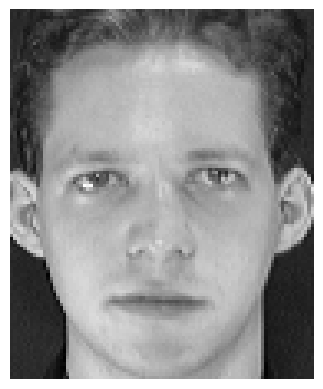

In [2]:
import cv2
import matplotlib.pyplot as plt

def read_pgm(file_path):
    return cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

def show_image(image_data):
    plt.imshow(image_data, cmap='gray')
    plt.axis('off')  # Hide axis labels
    plt.show()

file_path = f'../ATT images/s1/1.pgm'
image_data = read_pgm(file_path)
show_image(image_data)

In [3]:
image_data.shape

(112, 92)

In [4]:
def get_data(path_data='../ATT images', test_size=0.2, is_shuffle=True):
    folders = [f's{i+1}' for i in range(40)]
    X, y = [], []

    for i in range(1, 41):
        path = path_data + f'/s{i}'
        files = os.listdir(path)
        num_files = len(files)

        if is_shuffle:
            files = shuffle(files)

        for file in os.listdir(path):
            path = path_data + f'/s{i}/' + file
            image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            pixels = np.reshape(image, [1, image.shape[0] * image.shape[1]])
            pixels = np.asarray(pixels)

            if len(X) == 0:
                X = pixels
            else:
                X = np.vstack([X, pixels])
            y.append(f's{i}')

    return X, np.asarray(y)

In [5]:
X, y = get_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
n_components_pca = 50
pca = IncrementalPCA(n_components=n_components_pca)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

In [7]:
predictions = {}

# Euclidean

In [8]:
y_pred = []
for i in range(80):
    min_ = np.argmin(np.sqrt(np.sum((X_train_reduced - X_test_reduced[i])**2,axis=1)))
    y_pred.append(y_train[min_])

In [9]:
predictions['euclidean'] = y_pred

In [10]:
from sklearn.model_selection import KFold
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

****

**Chọn trường hợp accuracy của logistic model khác 1**

In [11]:
lr = LogisticRegression()
lr.fit(X_train_reduced, y_train)
y_pred = lr.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

accuracy: 0.975
recall: 0.9791666666666666
precision: 0.9837962962962963
f1-score: 0.9772486772486771
roc_auc:  0.9892248954748956


C:\Users\Hải Nam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Random Forest

In [12]:
prediction_results = {}

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

**Normal**

In [14]:
rfr = RandomForestClassifier(random_state=42)
rfr.fit(X_train_reduced,y_train)
y_pred = rfr.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

accuracy: 0.9
recall: 0.9074074074074073
precision: 0.9027777777777778
f1-score: 0.8898148148148147
roc_auc:  0.7587202908274576


C:\Users\Hải Nam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Tunning**

In [15]:
import optuna


def objective(trial):
    hyperparams = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 10, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 32),
        'random_state': trial.suggest_categorical('random_state', [42]),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 32),
        'n_jobs': -1
    }

    model = RandomForestClassifier(**hyperparams)
    scores = cross_val_score(model, X_train_reduced,
                             y_train, cv=kf, scoring='accuracy')
    return np.mean(scores)

In [16]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)
best_params = study.best_params
print("Best params found :", best_params)

final_model = RandomForestClassifier(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

[I 2024-02-17 23:17:16,208] A new study created in memory with name: no-name-73fc9b2f-e5ad-4f83-9252-77c47a1c6f5d
[I 2024-02-17 23:17:19,972] Trial 0 finished with value: 0.7 and parameters: {'n_estimators': 505, 'max_depth': 32, 'min_samples_split': 4, 'random_state': 42, 'min_samples_leaf': 17}. Best is trial 0 with value: 0.7.
[I 2024-02-17 23:17:22,925] Trial 1 finished with value: 0.76875 and parameters: {'n_estimators': 385, 'max_depth': 16, 'min_samples_split': 11, 'random_state': 42, 'min_samples_leaf': 12}. Best is trial 1 with value: 0.76875.
[I 2024-02-17 23:17:27,053] Trial 2 finished with value: 0.546875 and parameters: {'n_estimators': 569, 'max_depth': 21, 'min_samples_split': 16, 'random_state': 42, 'min_samples_leaf': 29}. Best is trial 1 with value: 0.76875.
[I 2024-02-17 23:17:29,387] Trial 3 finished with value: 0.525 and parameters: {'n_estimators': 317, 'max_depth': 18, 'min_samples_split': 25, 'random_state': 42, 'min_samples_leaf': 31}. Best is trial 1 with valu

Best params found : {'n_estimators': 578, 'max_depth': 17, 'min_samples_split': 3, 'random_state': 42, 'min_samples_leaf': 1}


0.95

In [17]:
final_model = RandomForestClassifier(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['random forest'] = y_pred 

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

accuracy: 0.95
recall: 0.9583333333333334
precision: 0.9657407407407407
f1-score: 0.9504629629629631
roc_auc:  0.9784520449077411


****

# Gassian NB

**Pre-tunning**

In [18]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train_reduced, y_train)

y_pred = gnb.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# # ROC AUC score with multiclass handling
# roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovr')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
# print('roc_auc: ', roc_auc_macro)


accuracy: 0.925
recall: 0.9031531531531531
precision: 0.9076576576576577
f1-score: 0.8922779922779922


C:\Users\Hải Nam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hải Nam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Tunning**

In [19]:
def objective(trial):
    hyperparams = {
        'var_smoothing': trial.suggest_float('var_smoothing', 1e-9, 1e-4, log = True)
    }
    
    model = GaussianNB(**hyperparams)
    scores = cross_val_score(model, X_train_reduced, y_train, cv = kf,scoring = 'accuracy')
    return np.mean(scores)

In [20]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)
best_params = study.best_params
print("Best params found :", best_params)

final_model = GaussianNB(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['logistic regression'] = y_pred 

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# # One-hot encoding for probability calculation (adapt if necessary)
# y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
# y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# # ROC AUC score with multiclass handling
# roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
# print('roc_auc: ', roc_auc_macro)

[I 2024-02-17 23:25:38,880] A new study created in memory with name: no-name-4b8a91d6-cc60-433d-83a8-805a8c7d7017
[I 2024-02-17 23:25:38,915] Trial 0 finished with value: 0.746875 and parameters: {'var_smoothing': 1.1880230413935817e-07}. Best is trial 0 with value: 0.746875.
[I 2024-02-17 23:25:38,945] Trial 1 finished with value: 0.746875 and parameters: {'var_smoothing': 2.495997457615255e-08}. Best is trial 0 with value: 0.746875.
[I 2024-02-17 23:25:38,974] Trial 2 finished with value: 0.746875 and parameters: {'var_smoothing': 1.0761389067042044e-09}. Best is trial 0 with value: 0.746875.
[I 2024-02-17 23:25:39,002] Trial 3 finished with value: 0.746875 and parameters: {'var_smoothing': 1.000945069328262e-05}. Best is trial 0 with value: 0.746875.
[I 2024-02-17 23:25:39,031] Trial 4 finished with value: 0.746875 and parameters: {'var_smoothing': 2.2844070558975428e-06}. Best is trial 0 with value: 0.746875.
[I 2024-02-17 23:25:39,057] Trial 5 finished with value: 0.746875 and par

Best params found : {'var_smoothing': 9.289817182670932e-05}
accuracy: 0.925
recall: 0.9031531531531531
precision: 0.9076576576576577
f1-score: 0.8922779922779922


C:\Users\Hải Nam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hải Nam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


****

# Logistic Regression

**Normal**

In [21]:
lr = LogisticRegression()
lr.fit(X_train_reduced, y_train)
y_pred = lr.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# # One-hot encoding for probability calculation (adapt if necessary)
# y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
# y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# # ROC AUC score with multiclass handling
# roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
# print('roc_auc: ', roc_auc_macro)

C:\Users\Hải Nam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy: 0.975
recall: 0.9791666666666666
precision: 0.9837962962962963
f1-score: 0.9772486772486771


**Tunning**

In [22]:
import optuna
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')


def objective(trial):
    hyperparams = {
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'newton-cg', 'saga']),
        'penalty': trial.suggest_categorical('penalty', ['l2']),
        'multi_class': trial.suggest_categorical('multi_class', ['ovr']),
        'C': trial.suggest_loguniform("C", 1e-3, 1e3),
        'n_jobs': -1
    }

    model = LogisticRegression(**hyperparams)
    scores = cross_val_score(model, X_train_reduced,
                             y_train, cv=kf, scoring='accuracy')
    return np.mean(scores)

In [23]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)
best_params = study.best_params
print("Best params found :", best_params)

final_model = LogisticRegression(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['logistic regression'] = y_pred 

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

[I 2024-02-17 23:25:41,847] A new study created in memory with name: no-name-d91fe04c-0d3e-4807-a56c-78411593fcce
[I 2024-02-17 23:25:45,925] Trial 0 finished with value: 0.928125 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'multi_class': 'ovr', 'C': 32.90335748698603}. Best is trial 0 with value: 0.928125.
[I 2024-02-17 23:25:46,438] Trial 1 finished with value: 0.859375 and parameters: {'solver': 'saga', 'penalty': 'l2', 'multi_class': 'ovr', 'C': 244.93266689832635}. Best is trial 0 with value: 0.928125.
[I 2024-02-17 23:25:49,576] Trial 2 finished with value: 0.921875 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'multi_class': 'ovr', 'C': 0.09352093192439799}. Best is trial 0 with value: 0.928125.
[I 2024-02-17 23:25:50,114] Trial 3 finished with value: 0.859375 and parameters: {'solver': 'saga', 'penalty': 'l2', 'multi_class': 'ovr', 'C': 0.0010957868144159204}. Best is trial 0 with value: 0.928125.
[I 2024-02-17 23:25:50,627] Trial 4 finished with value: 

Best params found : {'solver': 'lbfgs', 'penalty': 'l2', 'multi_class': 'ovr', 'C': 0.017789665830253012}
accuracy: 0.9875
recall: 0.9861111111111112
precision: 0.9907407407407407
f1-score: 0.9851851851851853
roc_auc:  0.9928774928774929


In [24]:
# lr = LogisticRegression(multi_class='ovr', solver='liblinear')
# lr.fit(X_train_reduced, y_train)
# y_pred = lr.predict(X_test_reduced)

# KNN Classifier

**Normal**

In [25]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train_reduced, y_train)
y_pred = knn.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)


accuracy: 0.925
recall: 0.9421296296296295
precision: 0.9495370370370372
f1-score: 0.9279761904761905
roc_auc:  0.9699917551974515


**Tunning**

In [26]:
import optuna
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

def objective(trial):
    hyperparams = {
        'n_neighbors': trial.suggest_int("n_neighbors", 5, 100),
        'weights' : trial.suggest_categorical("weights", ["uniform", "distance"]),
        'metric' : trial.suggest_categorical("metric", ["euclidean", "manhattan", "minkowski"]),
        'algorithm':trial.suggest_categorical('algorithm',['auto', 'ball_tree', 'kd_tree', 'brute']),
        'n_jobs': -1
    }
    
    # Create KNN model with tuned hyperparameters
    model = KNeighborsClassifier(**hyperparams)
    scores = cross_val_score(model, X_train_reduced, y_train, cv = kf,scoring = 'accuracy')
    return np.mean(scores)

In [27]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)
best_params = study.best_params
print("Best params found :", best_params)

final_model =KNeighborsClassifier(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['KNN'] = y_pred 

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

[I 2024-02-17 23:31:34,186] A new study created in memory with name: no-name-f8b7f759-1287-46c2-a9ac-8c2ba5df268d
[I 2024-02-17 23:31:34,232] Trial 0 finished with value: 0.109375 and parameters: {'n_neighbors': 63, 'weights': 'uniform', 'metric': 'euclidean', 'algorithm': 'auto'}. Best is trial 0 with value: 0.109375.
[I 2024-02-17 23:31:34,271] Trial 1 finished with value: 0.6 and parameters: {'n_neighbors': 43, 'weights': 'distance', 'metric': 'manhattan', 'algorithm': 'auto'}. Best is trial 1 with value: 0.6.
[I 2024-02-17 23:31:34,313] Trial 2 finished with value: 0.55625 and parameters: {'n_neighbors': 95, 'weights': 'distance', 'metric': 'manhattan', 'algorithm': 'auto'}. Best is trial 1 with value: 0.6.
[W 2024-02-17 23:31:34,327] Trial 3 failed with parameters: {'n_neighbors': 38, 'weights': 'uniform', 'metric': 'manhattan', 'algorithm': 'brute'} because of the following error: The value nan is not acceptable.
[W 2024-02-17 23:31:34,327] Trial 3 failed with value nan.
[I 2024-

Best params found : {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'algorithm': 'brute'}
accuracy: 0.9375
recall: 0.949074074074074
precision: 0.9564814814814816
f1-score: 0.9393518518518518
roc_auc:  0.9736443526000489


Tuning rồi lưu kết quả tuning vào bên dưới

In [28]:
predictions['lr'] = list(y_pred)

In [29]:
import json
with open("/kaggle/working/predict.json", "w") as json_file:
    json.dump(predictions, json_file)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/predict.json'

In [ ]:
prediction = {}